In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from utils import set_seed
from plot_utils import plot_eval_results

set_seed()


In [14]:

from mnist_utils import plot_samples
from config import cfg
from vanilla_model import fit as fit_vanilla
from metrics import calc_metrics
from converters import Converter
from config import cfg
from eval import run_tflite_model
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu
from model import get_model
from model import save_pruned_model
from utils import get_gzipped_model_size

In [18]:
from nyuv2_torch_ds_adapter import get_tf_nyuv2_ds
import argparse
args = argparse.Namespace()
args.truncate_testset = False
# args.target_size = (64, 64)
args.crop_size = (640, 480)
# args.target_size = (64, 64)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
args.batch_size=cfg.batch_size*4

ds_train, ds_val, ds_test = get_tf_nyuv2_ds(cfg.base_kitti_dataset_dir, args)
# train_size=cfg.take_first_n
# ds_train = ds_train.take(train_size)
# val_size=cfg.take_first_n
# ds_val = ds_val.take(val_size)
# test_size=cfg.take_first_n
# ds_test = ds_test.take(test_size)

x_val= next(iter(ds_val))
x_train= next(iter(ds_train))

Dataset: NYU Depth V2
# of train images: 50688
Dataset: NYU Depth V2
# of test images: 654
Train size:  40551
Val size:  10137
Test size:  654


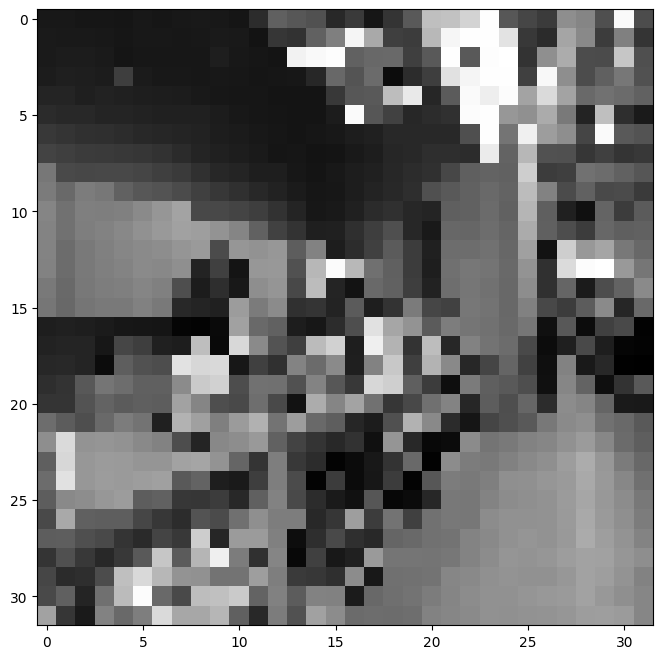

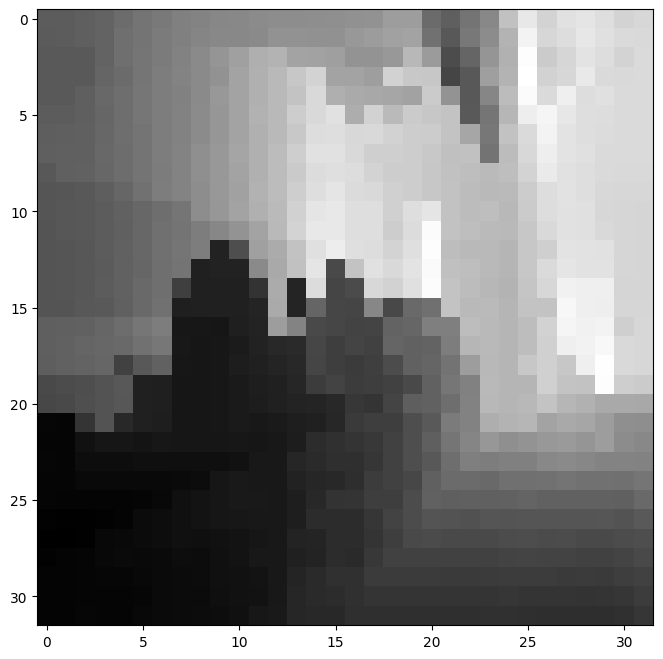

In [21]:
plt.imshow(x_train[0][0])
plt.show()
plt.imshow(x_train[1][0])
plt.show()

In [22]:
import os
converter = Converter(cfg)

cfg.save_model_dir = "/tmp/models"
cfg.save_cfiles_dir = "/tmp/cfiles"
cfg.save_test_data_dir = "/tmp/test_data"
cfg.do_overfit = True

os.makedirs(cfg.save_model_dir, exist_ok=True)
os.makedirs(cfg.save_cfiles_dir, exist_ok=True)
os.makedirs(cfg.save_test_data_dir, exist_ok=True)

In [23]:
model_names = [
    "depth_model_quant8_dynR",
    "depth_full_quant",
    "depth_qat_int8",
    "pruned_model",
    "pruned_model_unstructured",
    "pruned_model_unstructured_dynamic",
    "pruned_qat_model",
    "depth_model_fp32",
]
cfiles = {
    "depth_model_quant8_dynR": "depth_model_quant8_dynR",
    "depth_full_quant": "q8depth",
    "depth_qat_int8": "qat8depth",
    "pruned_model": "pruned",
    "pruned_model_unstructured": "pruned_unstructured",
    "pruned_model_unstructured_dynamic": "pruned_unstructured_dynamic",
    "pruned_qat_model": "pruned_unstructured_qat_model",
    "depth_model_fp32": "depth_model_fp32",
}
save_test_data(cfg.save_test_data_dir, x_train[0], x_train[1])

Test image data location:  /tmp/test_data/x_test_depth.npy
Test labels location:  /tmp/test_data/y_test_depth.npy


In [24]:
import pickle
from eval import eval_model
from loss import calculate_loss
from model import get_model
import tensorflow_model_optimization as tfmot


def fit_eval(model, model_name, do_save_model=True, epochs=cfg.epochs, do_savefig=True):
    keras.backend.clear_session()
    # loss = tf.keras.losses.MeanSquaredError()
    metrics = tf.keras.metrics.Mean(name="loss")

    # Define a custom metric
    def custom_metric(y_true, y_pred, sample_weight=None):
        metric_value = calculate_loss(y_true, y_pred)
        metrics.update_state(metric_value, sample_weight=sample_weight)
        return metric_value

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss="mae", metrics=[custom_metric])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.2, min_lr=1e-7, patience=5, min_delta=1e-2, verbose=1
    )
    callbacks = [reduce_lr]
    if "pruned" in model_name:
        callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
    if not cfg.do_overfit:
        tbCallBack = tf.keras.callbacks.TensorBoard(
            log_dir=f"{cfg.logdir}/tb_logs",
            histogram_freq=0,
            write_graph=False,
            write_images=False,
        )
        es = tf.keras.callbacks.EarlyStopping(
            patience=cfg.es_patience, restore_best_weights=True
        )
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=cfg.logdir + f"/{model_name}",
            save_weights_only=True,
            monitor="custom_metric",
            mode="min",
            save_best_only=True,
        )
        callbacks.append(es)
        callbacks.append(model_checkpoint_callback)
        callbacks.append(tbCallBack)
    history = model.fit(
        x=ds_train,
        epochs=epochs,
        validation_data=ds_val,
        callbacks=callbacks,
        verbose=1,
    )
    # pickle history
    with open(f"{cfg.save_model_dir}/{model_name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)

    # plot history
    pu.plot_history(history, f"{cfg.save_model_dir}/{model_name}_history.png")
    if not do_savefig:
        plt.show()
    tflite_path=None
    model_tflite=None
    if do_save_model:
        model.save(f"{cfg.save_model_dir}/{model_name}.h5")
        model_tflite, tflite_path = converter.keras_to_tflite(model, model_name, do_return_path=True)
    # tflite_path='/tmp/models/depth_model_fp32.tflite'
    metrics = eval_model(
        model=model,
        test_ds=ds_val,
        tflite_path=tflite_path,
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
    return model_tflite, metrics, history

In [7]:
# load history
# with open(f"{cfg.save_model_dir}/{model_names[7]}_history.pkl", "rb") as f:
#     history2 = pickle.load(f)
# pu.plot_history(history2, f"{cfg.save_model_dir}/{model_names[7]}_history.png")

16/16 [==============================] - 60s 4s/step - loss: 0.7529 - custom_metric: 1.2580 - val_loss: 0.1191 - val_custom_metric: 1.1990 - lr: 5.0000e-04


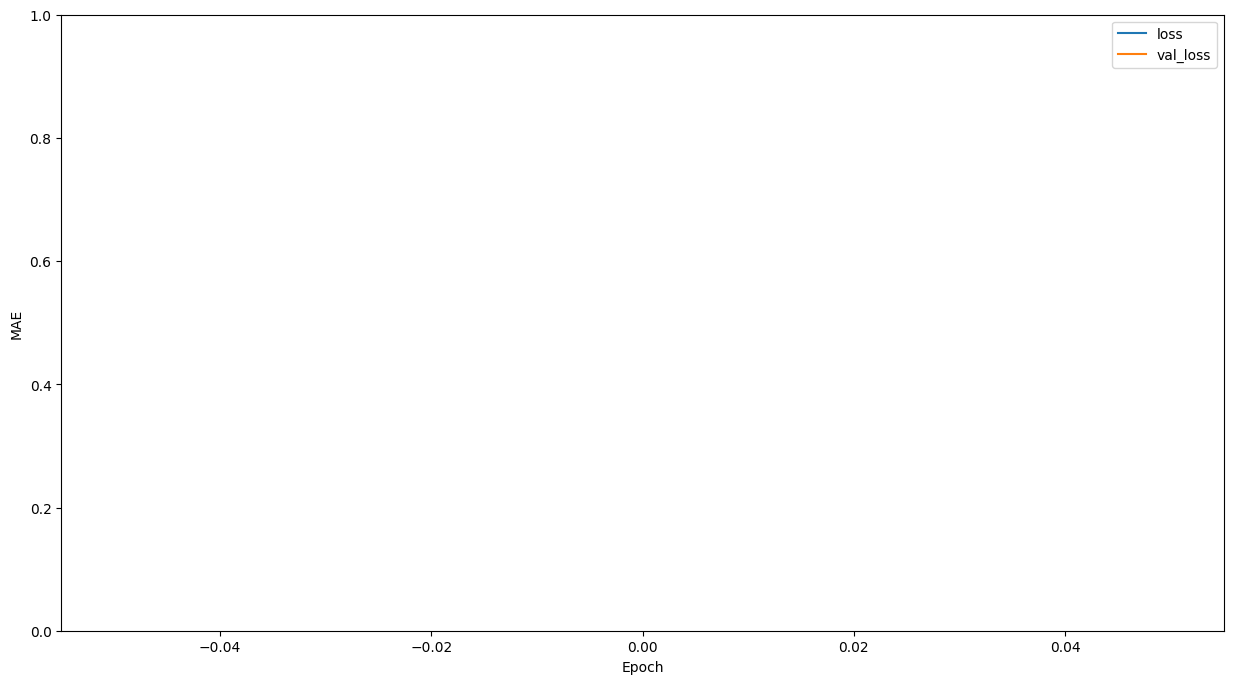

INFO:tensorflow:Assets written to: /tmp/tmpp5ysy15y/assets


INFO:tensorflow:Assets written to: /tmp/tmpp5ysy15y/assets


Model was saved at location: /tmp/models/depth_model_fp32.tflite
HDF5 Model size: 1142 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 3.796482
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
depth_model_fp32 model metrics:
mse: 0.019
mae: 0.119
eval_loss: 0.119
eval_metric: 1.199
Saved metrics to /tmp/models/metrics.json


INFO:tensorflow:Assets written to: /tmp/tmpxpa27g8z/assets


INFO:tensorflow:Assets written to: /tmp/tmpxpa27g8z/assets


Model was saved at location: /tmp/models/depth_model_fp32.tflite
HDF5 Model size: 1142 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 3.796482


In [26]:
# Build model
keras.backend.clear_session()
fp_model = get_model(
    cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels, use_qat=False,
    do_downsample_model=True
)
fit_eval(fp_model, model_names[7], epochs=1)
model_tflite, tflite_path = converter.keras_to_tflite(fp_model, model_names[7], do_return_path=True)
write_model_h(cfiles[model_names[7]], model_tflite, cfg.save_cfiles_dir)

4/4 [==============================] - 0s 3ms/step
MAE: 0.13, RMSE: 0.02, loss: 1.09


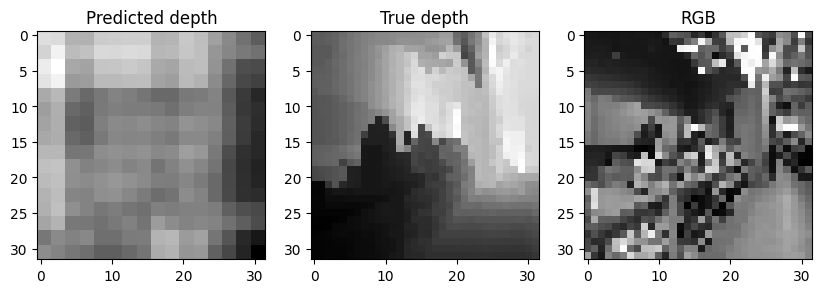

In [30]:

out = fp_model.predict(x_train[0])
plot_eval_results(out[0], x_train[1][0], x_train[0][0])

In [32]:
dynR_quant_tflite_model = converter.dynamic_range_quantization(fp_model, model_names[0])

INFO:tensorflow:Assets written to: /tmp/tmpy12_1edu/assets


INFO:tensorflow:Assets written to: /tmp/tmpy12_1edu/assets


Model was saved at location: /tmp/models/depth_model_quant8_dynR.tflite


In [34]:
tflite_model_quant_int8=converter.eight_bit_quantization(fp_model, ds_train, model_name=model_names[1])
converter.check_quantized_model(tflite_model_quant_int8)

INFO:tensorflow:Assets written to: /tmp/tmp6yth9mna/assets


INFO:tensorflow:Assets written to: /tmp/tmp6yth9mna/assets
/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model was saved at location: /tmp/models/depth_full_quant.tflite
TFLite Model size with 8-bit quantization: 108 KB
TFLite Model size without quantization: 300 KB

Reduction in model size by a factor of 2.779843
input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [35]:
depth_full_quant_tflite_path=f'{cfg.save_model_dir}/{model_names[1]}.tflite'
eval_model(
        ds_val,
        tflite_path=depth_full_quant_tflite_path,
        model=None,
        model_name=model_names[1],
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_names[1]], tflite_model_quant_int8, cfg.save_cfiles_dir)

Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
depth_full_quant model metrics:
mse: 19016.324
mae: 137.433
eval_loss: -1.000
eval_metric: -1.000
Saved metrics to /tmp/models/metrics.json


In [29]:
# Convert the model to a quantization aware model
quant_aware_model = get_model(
    cfg.img_size, cfg.num_classes, in_channels=3, use_qat=True
)
model_name = model_names[2]
fit_eval(quant_aware_model, model_name)
quant_aware_model_converted = converter.eight_bit_quantization(
    quant_aware_model, ds_train, model_name=model_name
)
write_model_h(cfiles[model_name], quant_aware_model_converted, cfg.save_cfiles_dir)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.8796 - custom_metric: 1.2940 - val_loss: 0.2995 - val_custom_metric: 1.0563 - lr: 1.0000e-04
Epoch 2/5
1/1 [==============================] - 0s 73ms/step - loss: 0.8155 - custom_metric: 1.3239 - val_loss: 0.2537 - val_custom_metric: 0.9777 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 0s 76ms/step - loss: 0.7753 - custom_metric: 1.3056 - val_loss: 0.2203 - val_custom_metric: 0.9015 - lr: 1.0000e-04
Epoch 4/5
1/1 [==============================] - 0s 78ms/step - loss: 0.7466 - custom_metric: 1.2851 - val_loss: 0.1861 - val_custom_metric: 0.8344 - lr: 1.0000e-04
Epoch 5/5
1/1 [==============================] - 0s 74ms/step - loss: 0.7388 - custom_metric: 1.2217 - val_loss: 0.1856 - val_custom_metric: 0.8464 - lr: 1.0000e-04


Model was saved at location: /tmp/models/depth_qat_int8.tflite
HDF5 Model size: 3810 KB
TFLite Model size: 2315 KB

Reduction in file size by a factor of 1.645855
depth_qat_int8 model metrics:
mse: 0.602
mae: 0.752
eval_loss: 0.752
eval_metric: 1.105
Saved metrics to /tmp/models/metrics.json


/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Model was saved at location: /tmp/models/depth_qat_int8.tflite
TFLite Model size with 8-bit quantization: 328 KB
TFLite Model size without quantization: 511 KB

Reduction in model size by a factor of 1.557951


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 0.6185 - custom_metric: 1.4211 - val_loss: 0.1034 - val_custom_metric: 0.9055 - lr: 5.0000e-04
Epoch 2/100
16/16 [==============================] - 16s 1s/step - loss: 0.3245 - custom_metric: 1.2616 - val_loss: 0.0569 - val_custom_metric: 0.6039 - lr: 5.0000e-04
Epoch 3/100
16/16 [==============================] - 17s 1s/step - loss: 0.1902 - custom_metric: 1.0889 - val_loss: 0.0598 - val_custom_metric: 0.4683 - lr: 5.0000e-04
Epoch 4/100
16/16 [==============================] - 17s 1s/step - loss: 0.1287 - custom_metric: 0.9639 - val_loss: 0.0615 - val_custom_metric: 0.4331 - lr: 5.0000e-04
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.0962 - custom_metric: 0.8608 - val_loss: 0.0537 - va

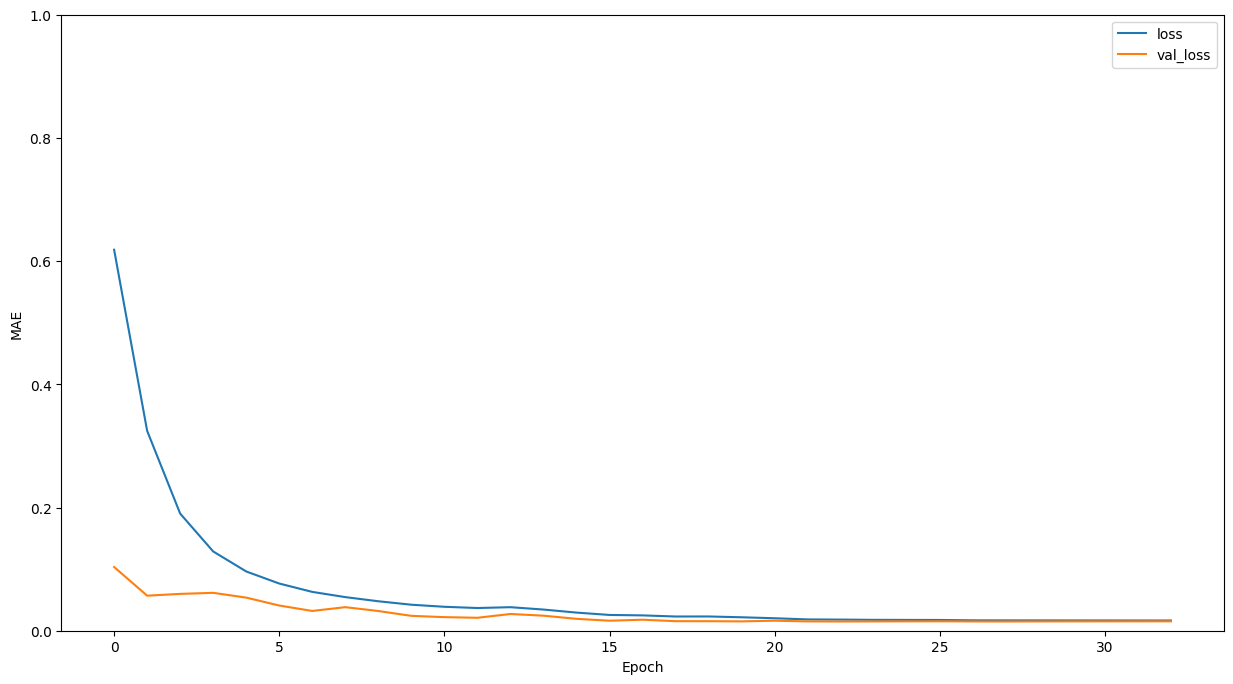

INFO:tensorflow:Assets written to: /tmp/tmpli66fn9q/assets


INFO:tensorflow:Assets written to: /tmp/tmpli66fn9q/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model.tflite
HDF5 Model size: 648 KB
TFLite Model size: 1160 KB

Reduction in file size by a factor of 0.559035


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_model model metrics:
mse: 0.001
mae: 0.015
eval_loss: 0.015
eval_metric: 0.166
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model.h5


INFO:tensorflow:Assets written to: /tmp/tmpby3jd86l/assets


INFO:tensorflow:Assets written to: /tmp/tmpby3jd86l/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model.tflite
HDF5 Model size: 1270 KB
TFLite Model size: 1135 KB

Reduction in file size by a factor of 1.118424


<Figure size 1500x800 with 0 Axes>

In [7]:
model_name = model_names[3]
pruned_model = get_model(cfg.img_size, cfg.num_classes, in_channels=3, use_qat=False, use_pruning=True,
                         use_pruning_struct=True)
fit_eval(pruned_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(pruned_model, f"{cfg.save_model_dir}/{model_name}.h5")
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/100
16/16 [==============================] - 22s 1s/step - loss: 0.7992 - custom_metric: 1.2815 - val_loss: 0.1444 - val_custom_metric: 0.8684 - lr: 5.0000e-04
Epoch 2/100
16/16 [==============================] - 17s 1s/step - loss: 0.4158 - custom_metric: 1.3070 - val_loss: 0.1559 - val_custom_metric: 0.8073 - lr: 5.0000e-04
Epoch 3/100
16/16 [==============================] - 17s 1s/step - loss: 0.2310 - custom_metric: 1.1447 - val_loss: 0.2019 - val_custom_metric: 0.7973 - lr: 5.0000e-04
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.1524 - custom_metric: 1.0220 - val_loss: 0.1591 - val_custom_metric: 0.7373 - lr: 5.0000e-04
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.1188 - custom_metric: 0.9376 - val_loss: 0.0903 - val_custom_metric: 0.6173 - lr: 5.0000e-04
Epoch 6/100
16/16 [==============================] - 16s 1s/step - loss: 0.0966 - custom_metric: 0.8693 - val_loss: 0.0892 - val_custom_metric: 0.5959 - lr: 5.0

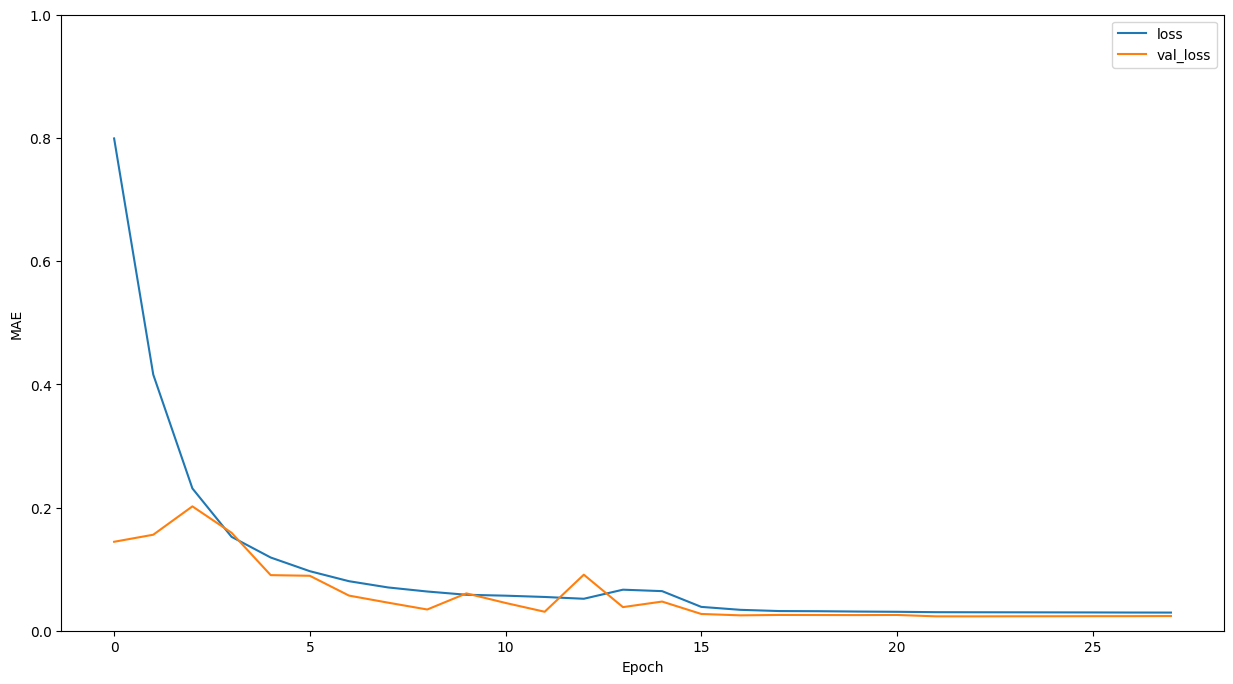

pruned_model_unstructured model metrics:
eval_loss: 0.023
eval_metric: 0.259
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured.h5


INFO:tensorflow:Assets written to: /tmp/tmpmdbnr47y/assets


INFO:tensorflow:Assets written to: /tmp/tmpmdbnr47y/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured.tflite
HDF5 Model size: 1270 KB
TFLite Model size: 1135 KB

Reduction in file size by a factor of 1.118424
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_model_unstructured model metrics:
mse: 0.001
mae: 0.023
eval_loss: 0.023
eval_metric: 0.259
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


<Figure size 1500x800 with 0 Axes>

In [13]:
model_name = model_names[4]
pruned_model_unstruct = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=3,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
)
fit_eval(pruned_model_unstruct, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_model_unstruct, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_model_unstruct,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 0.6807 - custom_metric: 1.4231 - val_loss: 0.1005 - val_custom_metric: 0.9847 - lr: 5.0000e-04
Epoch 2/100
16/16 [==============================] - 16s 1s/step - loss: 0.4033 - custom_metric: 1.3246 - val_loss: 0.1497 - val_custom_metric: 1.1799 - lr: 5.0000e-04
Epoch 3/100
16/16 [==============================] - 16s 1s/step - loss: 0.2926 - custom_metric: 1.1933 - val_loss: 0.1047 - val_custom_metric: 1.2125 - lr: 5.0000e-04
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.2135 - custom_metric: 1.1227 - val_loss: 0.0936 - val_custom_metric: 1.2183 - lr: 5.0000e-04
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.1668 - custom_metric: 1.0609 - val_loss: 0.1096 - val_custom_metric: 1.2523 - lr: 5.0000e-04
Epoch 6/100
16/16 [==============================] - 16s 1s/step - loss: 0.1341 - custom_metric: 0.9954 - val_loss: 0.0827 - val_custom_metric: 1.2221 - lr: 5.0

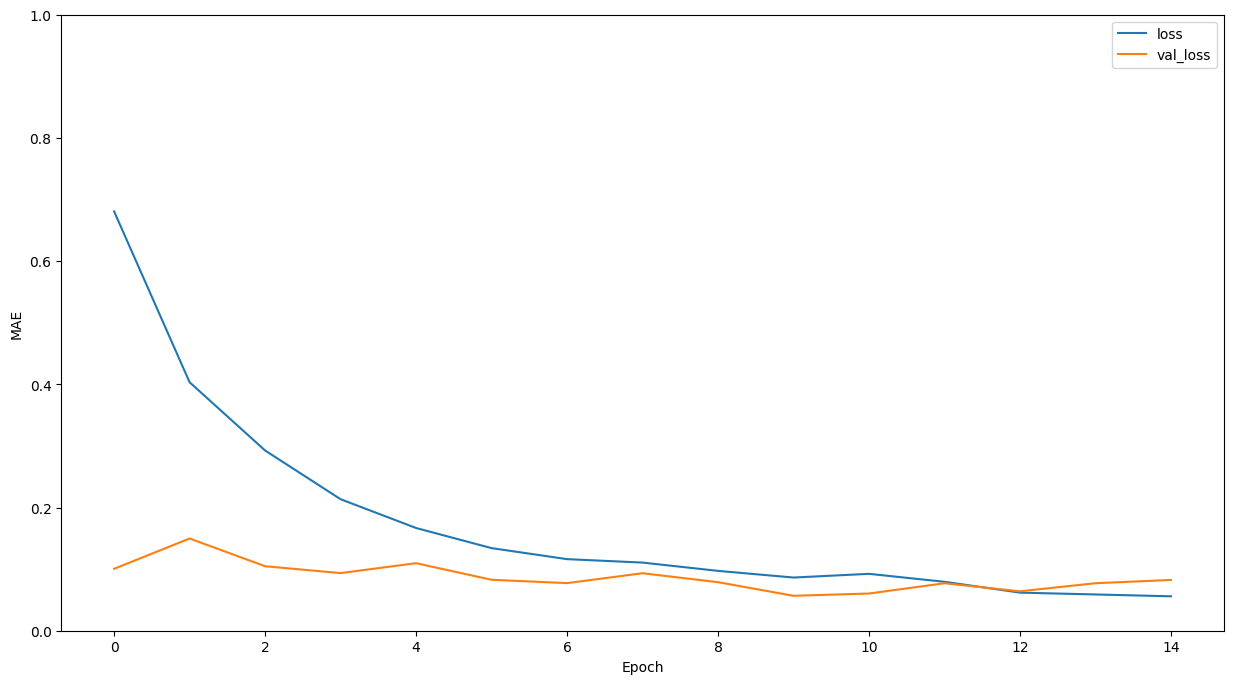

pruned_model_unstructured_dynamic model metrics:
eval_loss: 0.057
eval_metric: 1.040
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured_dynamic.h5


INFO:tensorflow:Assets written to: /tmp/tmp7dgvgask/assets


INFO:tensorflow:Assets written to: /tmp/tmp7dgvgask/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured_dynamic.tflite
HDF5 Model size: 1270 KB
TFLite Model size: 1135 KB

Reduction in file size by a factor of 1.118424
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_model_unstructured_dynamic model metrics:
mse: 0.006
mae: 0.056
eval_loss: 0.057
eval_metric: 1.040
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


<Figure size 1500x800 with 0 Axes>

In [14]:
model_name = model_names[5]
pruned_model_unstruct_dynamic = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=3,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=True,
)
fit_eval(pruned_model_unstruct_dynamic, model_name, do_save_model=False)
pruned_model_unstructured_for_export = save_pruned_model(
    pruned_model_unstruct_dynamic, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_unstructured_for_export, model_name)
eval_model(
        model=pruned_model_unstruct_dynamic,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/100
16/16 [==============================] - 19s 1s/step - loss: 0.2172 - custom_metric: 1.0108 - val_loss: 0.0707 - val_custom_metric: 1.0593 - lr: 5.0000e-04
Epoch 2/100
16/16 [==============================] - 16s 1s/step - loss: 0.1164 - custom_metric: 0.9590 - val_loss: 0.0827 - val_custom_metric: 1.2224 - lr: 5.0000e-04
Epoch 3/100
16/16 [==============================] - 16s 1s/step - loss: 0.0915 - custom_metric: 0.8874 - val_loss: 0.0772 - val_custom_metric: 1.1900 - lr: 5.0000e-04
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.0798 - custom_metric: 0.8384 - val_loss: 0.0807 - val_custom_metric: 1.2220 - lr: 5.0000e-04
Epoch 5/100
16/16 [==============================] - 17s 1s/step - loss: 0.0735 - custom_metric: 0.8094 - val_loss: 0.0891 - val_custom_metric: 1.2416 - lr: 5.0000e-04
Epoch 6/100
16/16 [==============================] - 16s 1s/step - loss: 0.0684 - custom_metric: 0.7848 - val_loss: 0.0903 - val_custom_metric: 1.2415 - lr: 5.0

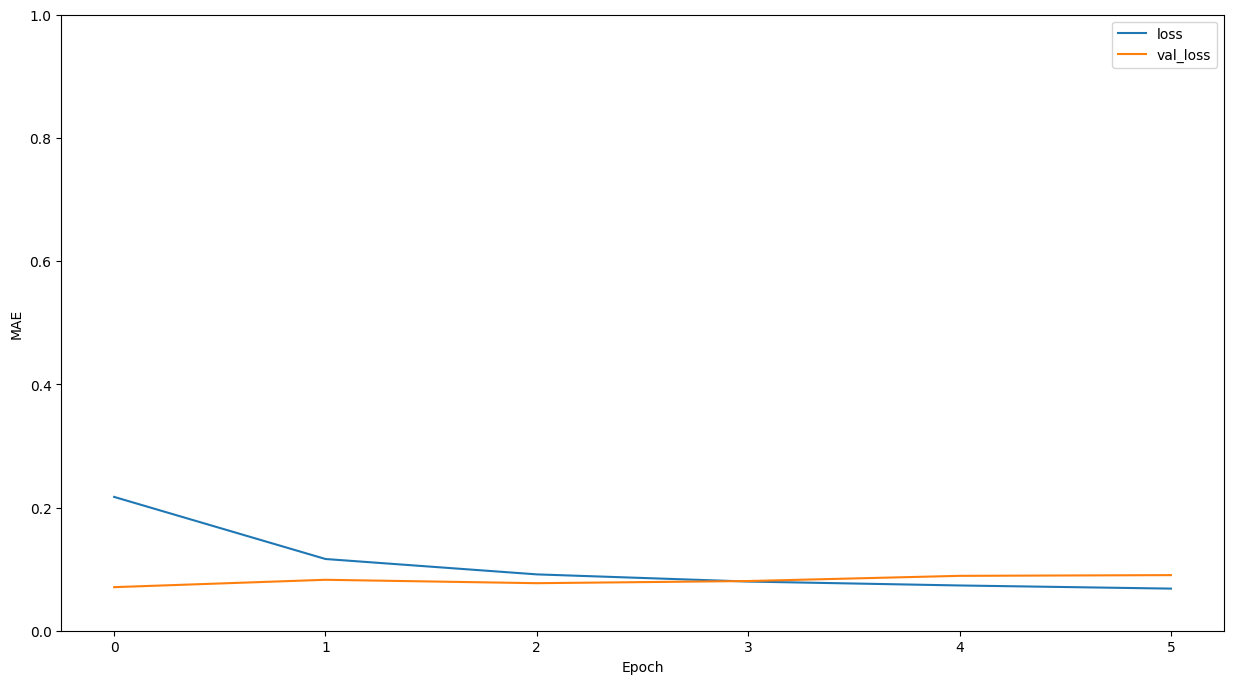

pruned_qat_model model metrics:
eval_loss: 0.071
eval_metric: 1.059
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_qat_model.h5


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_qat_model.tflite
HDF5 Model size: 1430 KB
TFLite Model size: 2315 KB

Reduction in file size by a factor of 0.617631
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_qat_model model metrics:
mse: 0.008
mae: 0.071
eval_loss: 0.071
eval_metric: 1.059
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


<Figure size 1500x800 with 0 Axes>

In [15]:
model_name = model_names[6]
pruned_qat_model = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=3,
    use_qat=True,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
    pruned_model_unstructured_for_export=pruned_model_unstructured_for_export
)
fit_eval(pruned_qat_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_qat_model, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_qat_model,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)